## Download the source code
Download the source code of the Mask R-CNN model.

In [ ]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


## Import library

In [ ]:
import cv2, sys, numpy as np
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')

import coco_metric
from PIL import Image
import tensorflow as tf
from IPython import display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from google.colab.patches import cv2_imshow
from mask_rcnn.object_detection import visualization_utils

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in the text.

In [ ]:
ID_MAPPING = {
    1: 'orang',
    2: 'sepeda pancal',
    3: 'mobil',
    4: 'sepeda motor',
    5: 'pesawat terbang',
    6: 'bus',
    7: 'kereta',
    8: 'truk',
    9: 'perahu',
    10: 'bangjo',
    11: 'pemadam',
    13: 'rambu berhenti',
    14: 'meteran parkir',
    15: 'bangku',
    16: 'burung',
    17: 'kucing',
    18: 'anjing',
    19: 'kuda',
    20: 'domba',
    21: 'sapi',
    22: 'gajah',
    23: 'beruang',
    24: 'zebra',
    25: 'jerapah',
    27: 'ransel',
    28: 'payung',
    31: 'tas tangan',
    32: 'dasi',
    33: 'koper',
    34: 'frisbee',
    35: 'ski',
    36: 'papan luncur salju',
    37: 'bola',
    38: 'layang-layang',
    39: 'tongkat baseball',
    40: 'sarung tangan baseball',
    41: 'skateboard',
    42: 'papan selancar',
    43: 'raket tenis',
    44: 'botol',
    46: 'gelas anggur',
    47: 'cangkir',
    48: 'garpu',
    49: 'pisau',
    50: 'sendok',
    51: 'mangkuk',
    52: 'pisang',
    53: 'apel',
    54: 'sandwich',
    55: 'jeruk',
    56: 'brokoli',
    57: 'wortel',
    58: 'hot dog',
    59: 'pizza',
    60: 'donat',
    61: 'kue',
    62: 'kursi',
    63: 'sofa',
    64: 'tanaman pot',
    65: 'tempat tidur',
    67: 'meja makan',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remot',
    76: 'keyboard',
    77: 'hp',
    78: 'microwave',
    79: 'oven',
    80: 'pemanggang roti',
    81: 'bak cuci',
    82: 'kulkas',
    84: 'buku',
    85: 'jam',
    86: 'vas bunga',
    87: 'gunting',
    88: 'boneka beruang',
    89: 'pengering rambut',
    90: 'sikat gigi',
}

category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image

--2023-01-11 12:11:00--  https://cdf.orami.co.id/unsafe/o-cdn-cas.sirclocdn.com/parenting/images/ciri-ciri-burung.width-800.jpegquality-80.jpg
Resolving cdf.orami.co.id (cdf.orami.co.id)... 54.192.81.90, 54.192.81.126, 54.192.81.63, ...
Connecting to cdf.orami.co.id (cdf.orami.co.id)|54.192.81.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50551 (49K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  49.37K  --.-KB/s    in 0.02s   

2023-01-11 12:11:01 (2.07 MB/s) - ‘test.jpg’ saved [50551/50551]



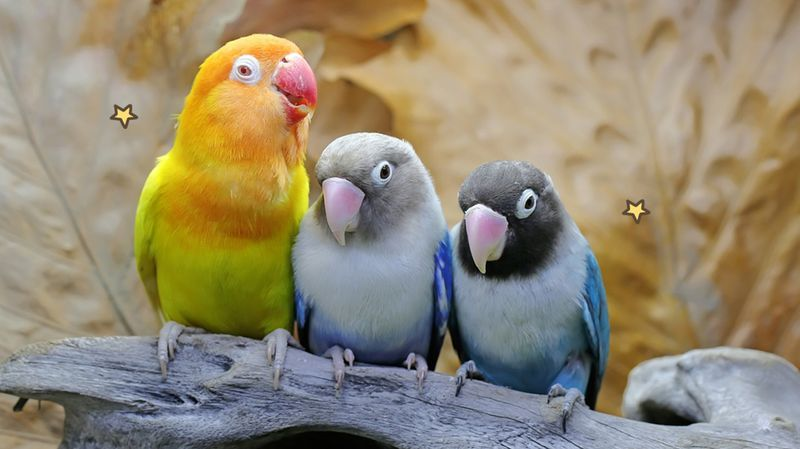

In [ ]:
!wget https://cdf.orami.co.id/unsafe/o-cdn-cas.sirclocdn.com/parenting/images/ciri-ciri-burung.width-800.jpegquality-80.jpg -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session

In [ ]:
session = tf.Session(graph=tf.Graph())

## Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket.

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


## Perform instance segmentation and retrieve the predictions

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))

detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]

detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]

detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]

instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]

ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)

processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)

segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
segmentations.shape

(9, 449, 800)

In [ ]:
!wget https://image.shutterstock.com/shutterstock/photos/1320935222/display_1500/stock-vector-rainbow-clouds-and-hearts-colorful-cute-rainbow-wallpaper-illustration-in-flat-style-summer-1320935222.jpg -O back.jpg

--2023-01-11 12:11:38--  https://image.shutterstock.com/shutterstock/photos/1320935222/display_1500/stock-vector-rainbow-clouds-and-hearts-colorful-cute-rainbow-wallpaper-illustration-in-flat-style-summer-1320935222.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 13.225.142.48, 13.225.142.56, 13.225.142.43, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|13.225.142.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1172272 (1.1M) [image/jpeg]
Saving to: ‘back.jpg’

back.jpg            100%[===================>]   1.12M  3.71MB/s    in 0.3s    

2023-01-11 12:11:39 (3.71 MB/s) - ‘back.jpg’ saved [1172272/1172272]



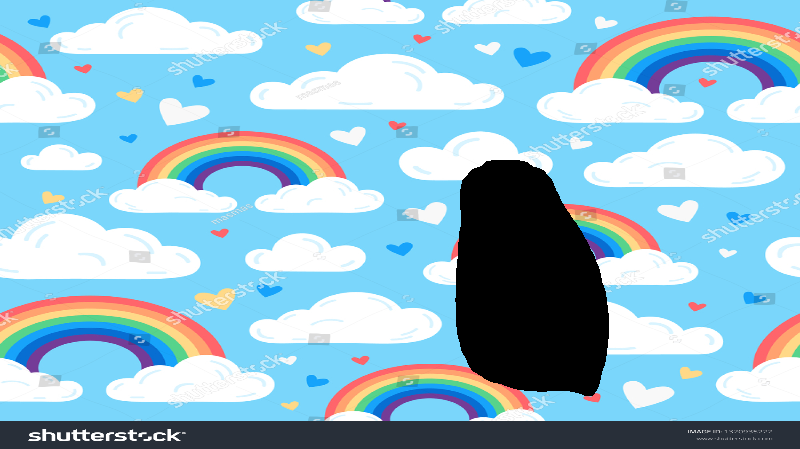

In [ ]:
back = cv2.imread('back.jpg')

back = cv2.resize(back, (800,449))
back = back[:866, :1300, :]

back *= (1-segmentations[0]).astype(np.uint8)[..., None]

cv2_imshow(back)

In [ ]:
hasil = segmentations[0]

for segmen in segmentations:
    hasil += segmen

hasil = (hasil > 0)*1

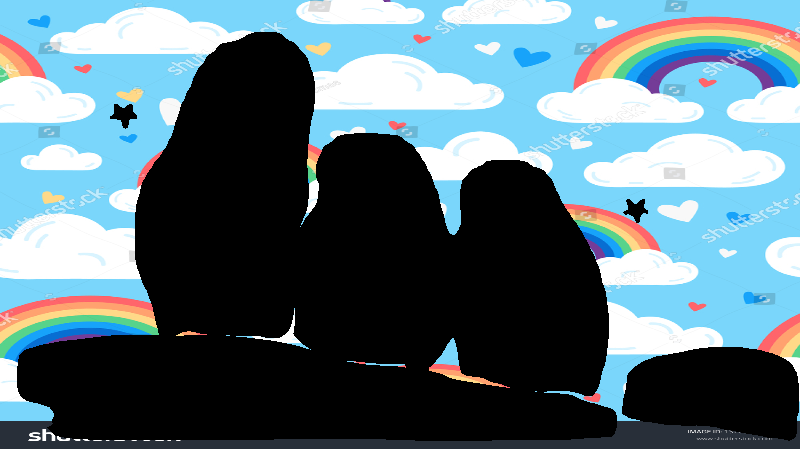

In [ ]:
back = cv2.imread('back.jpg')

back = cv2.resize(back, (800,449))
back = back[:866, :1300, :]

back *= (1-hasil).astype(np.uint8)[..., None]

cv2_imshow(back)

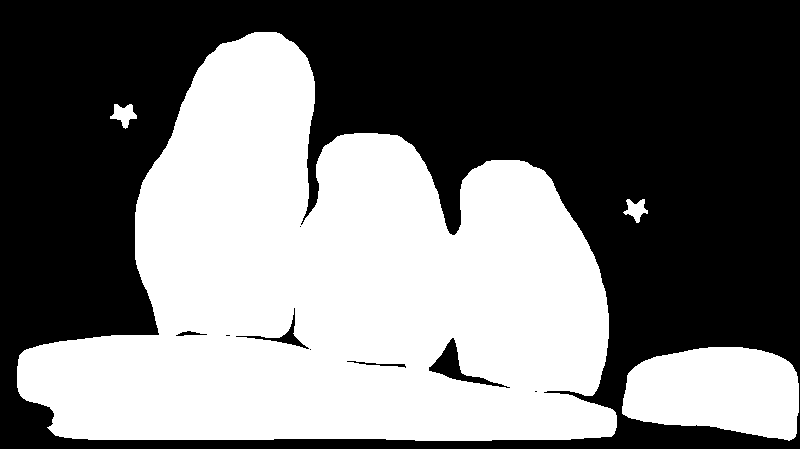

In [ ]:
cv2_imshow(hasil*255)

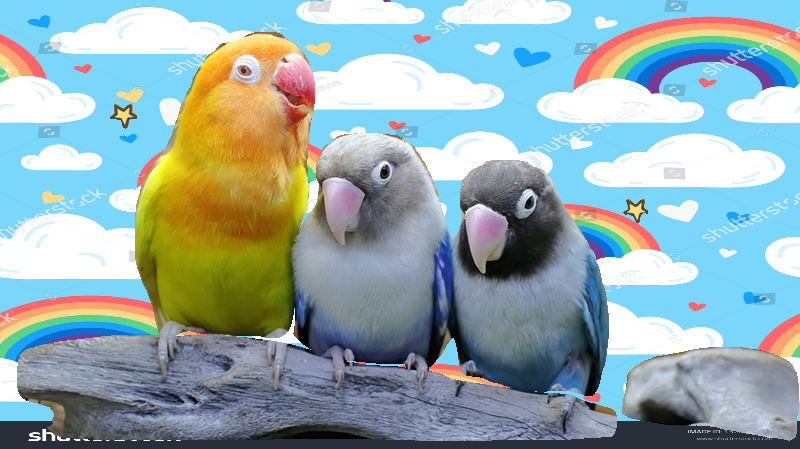

In [ ]:
embek = cv2.imread('test.jpg')

embek *= hasil.astype(np.uint8)[..., None]
embek += back

cv2_imshow(embek)

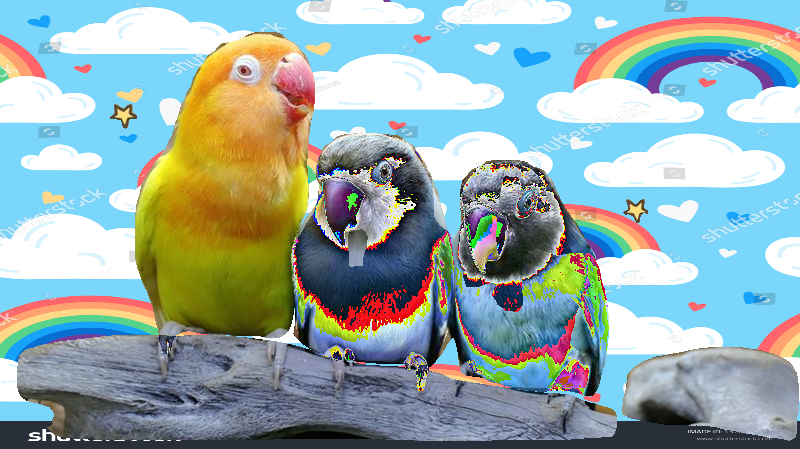

In [ ]:
embek = cv2.imread('test.jpg')

embek *= segmentations[0].astype(np.uint8)[..., None]
embek += back

cv2_imshow(embek)

In [ ]:
# CLASS
detection_classes[detection_classes==16].shape

(7,)